# Simulating excitatory-inhibitory Hodgkin-Huxley neuron networks using ``braincell``

This section introduces how to simulate a Hodgkin-Huxley (HH) type E-I network using `braincell`.

Before learning to model HH-type E-I networks with `braincell`, you should already be familiar with modeling HH-type [ion channels and neurons](braincell_HH_neuron-zh.ipynb).

## Overview of the E-I Network

In the last century, numerous neurobiological experiments revealed that even under repeated presentations of the same external stimulus, the spike sequences generated by neurons were different each time, and individual spike sequences exhibited highly irregular statistical behavior. At the same time, experiments showed that if connections between neurons were severed and a constant stimulus was applied to isolated cortical slices, neurons would fire regularly. This indicates that the irregular firing observed in the intact brain arises from the internal properties of the neuronal network rather than the characteristics of single neurons.

Therefore, beyond the single-neuron level, it is important to simulate and model networks composed of neurons.

Researchers also realized that a single neuron receives inputs from thousands of other neurons. If these presynaptic neurons fire independently and randomly, then according to the central limit theorem, their summed effect would not fluctuate much, leading the postsynaptic neuron to fire regularly—contradicting the experimental observations mentioned above. To resolve this contradiction, they proposed that the network should contain both excitatory and inhibitory neurons, and the inputs from these two types must be balanced and mutually canceling. In this case, the mean input received by a neuron remains small, while fluctuations are sufficiently large to induce irregular firing.

This led to the important concept of Excitation-Inhibition (E-I) balanced networks, which has been extensively validated experimentally, including in single neurons and inter-regional brain connections. E-I balanced networks are now widely accepted as a fundamental principle of brain connectivity.

A typical structure of such a network is shown below:

![E-I Balanced Network Structure](_static/image/braincell_HH_EI_network_structure.png)

Observing the network diagram, we see that synaptic connections exist both between and within neuron populations:

* Excitatory → Excitatory connections
* Excitatory → Inhibitory connections
* Inhibitory → Excitatory connections
* Inhibitory → Inhibitory connections

In addition to internal connections, the network also receives external current inputs.

## E-I Network Modeling

Before modeling an E-I network, we need neurons that have already been modeled.

First, we import the HH-type neurons from [Simulating Hodgkin-Huxley Neurons with `braincell`](braincell_HH_neuron-zh.ipynb):

In [1]:
import brainstate
import brainunit as u

import braincell

In [2]:
V_th = -20. * u.mV
area = 20000 * u.um ** 2
area = area.in_unit(u.cm ** 2)
Cm = (1 * u.uF * u.cm ** -2) * area  # Membrane Capacitance [pF]

In [3]:
class HH(braincell.SingleCompartment):
    def __init__(self, in_size):
        super().__init__(in_size, C=Cm, solver='ind_exp_euler')
        self.na = braincell.ion.SodiumFixed(in_size, E=50. * u.mV)
        self.na.add(INa=braincell.channel.INa_TM1991(in_size, g_max=100. * u.mS / u.cm ** 2 * area, V_sh=-63. * u.mV))

        self.k = braincell.ion.PotassiumFixed(in_size, E=-90 * u.mV)
        self.k.add(IK=braincell.channel.IK_TM1991(in_size, g_max=30. * u.mS / u.cm ** 2 * area, V_sh=-63. * u.mV))

        self.IL = braincell.channel.IL(in_size, E=-60. * u.mV, g_max=5. * u.nS / u.cm ** 2 * area)

To reduce modeling complexity, we simplify the E-I balanced network, retaining only excitatory and inhibitory connections for all neurons.

The network consists of 3,200 excitatory neurons and 800 inhibitory neurons, totaling 4,000 neurons.

In this example, the synaptic connection probability is 0.02, and the synaptic conductance is 6 nS.

The synapses are modeled as exponential decay synapses, governed by a first-order linear differential equation:

$$
\frac{dg}{dt} = -\frac{g}{\tau} + \text{input}(t)
$$

where:

* $g$: synaptic conductance
* $\tau$: decay time constant
* $\text{input}(t)$: input spikes from the presynaptic neuron

Based on this information, the network can be modeled as follows:

In [4]:

class EINet(brainstate.nn.DynamicsGroup):
    def __init__(self):
        super().__init__()
        self.n_exc = 3200
        self.n_inh = 800
        self.num = self.n_exc + self.n_inh
        self.N = HH(self.num)

        self.E = brainstate.nn.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(self.n_exc, self.num, conn_num=0.02, conn_weight=6. * u.nS),
            syn=brainstate.nn.Expon(self.num, tau=5. * u.ms),
            out=brainstate.nn.COBA(E=0. * u.mV),
            post=self.N
        )
        self.I = brainstate.nn.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(self.n_inh, self.num, conn_num=0.02, conn_weight=67. * u.nS),
            syn=brainstate.nn.Expon(self.num, tau=10. * u.ms),
            out=brainstate.nn.COBA(E=-80. * u.mV),
            post=self.N
        )

    def update(self, t):
        with brainstate.environ.context(t=t):
            spk = self.N.spike.value
            self.E(spk[:self.n_exc])
            self.I(spk[self.n_exc:])
            spk = self.N(0. * u.nA)
            return spk


By observing the code above, it is clear that the key aspect of network modeling lies in synapse modeling.

* `comm` allows you to choose different connectivity schemes, such as `FixedNumConn` or `EventFixedProb`
* `syn` allows you to choose different synapse types, such as `Expon`, `DualExpon`, `Alpha`, `AMPA`, or `GABAa`
* `out` allows you to choose different output modes, such as `COBA` or `CUBA`

For different connectivity schemes and synapse types, you only need to set the required parameters.

For example, in this case, the `EventFixedNumConn` connection requires specifying the number of presynaptic and postsynaptic neurons, the connection probability, and the synaptic conductance. The `Expon` synapse requires specifying the number of presynaptic neurons and the synaptic conductance decay time constant.

These components are preconfigured in the `braincell` framework and can be replaced as needed according to specific modeling requirements.

Simulation can be performed as follows:

In [5]:
# network
net = EINet()
brainstate.nn.init_all_states(net)

EINet(
  layers_tuple=(),
  layers_dict={},
  n_exc=3200,
  n_inh=800,
  num=4000,
  N=HH(
    in_size=(4000,),
    out_size=(4000,),
    current_inputs={
      'AlignPostProj0': COBA(
        E=0. * mvolt
      ),
      'AlignPostProj1': COBA(
        E=-80. * mvolt
      )
    },
    ion_channels={},
    C=0.0002 * ufarad,
    V_th=0. * mvolt,
    V_initializer=Uniform(
      min_val=-70 * mvolt,
      max_val=-60. * mvolt,
      rng=RandomState([3160710935 1907695982]),
      unit=Unit(10.0^0)
    ),
    spk_fun=ReluGrad(alpha=0.3, width=1.0),
    solver=<function ind_exp_euler_step at 0x0000028920D13060>,
    na=SodiumFixed(
      size=(4000,),
      name=None,
      channels={
        'INa': INa_TM1991(
          size=(4000,),
          name=None,
          phi=1.0,
          g_max=0.02 * msiemens,
          V_sh=-63. * mvolt,
          p=DiffEqState(
            value=ShapedArray(float32[4000]),
            _derivative=None,
            _diffusion=None
          ),
          q=Di

In [6]:
# simulation
with brainstate.environ.context(dt=0.1 * u.ms):
    times = u.math.arange(0. * u.ms, 100. * u.ms, brainstate.environ.get_dt())
    spikes = brainstate.compile.for_loop(net.update, times, pbar=brainstate.compile.ProgressBar(10))


  0%|          | 0/1000 [00:00<?, ?it/s]

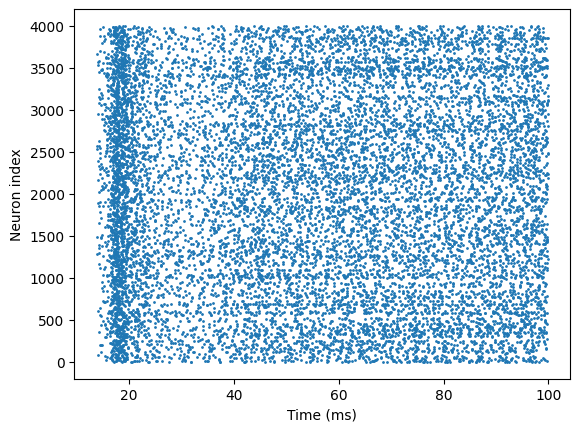

In [7]:
import matplotlib.pyplot as plt

# visualization
t_indices, n_indices = u.math.where(spikes)
plt.scatter(times[t_indices], n_indices, s=1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.show()

By observing the simulation results, it is clear that the HH-type E-I neural network we constructed generates spikes and exhibits rich electrophysiological properties.

The example models in this article are adapted from:

* Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies, *J. Comput. Neurosci.*, 23(3), 349–398.